svi - decoder for continuous y:
    
the key is to represent important quantities as random variables, and then sample from them:
    
$s \sim \mathcal{N}(\cdot, \cdot)$,

$z \sim \text{Categorical}(\pi)$,

$\pi = \lambda / \sum \lambda$,

$\log(\lambda) \sim \mathcal{N}(b + \beta y, 0)$,

$y \sim \mathcal{GP}(\cdot, \cdot)$

(remember to specify the priors for these R.V.s)

when calculate the elbo, we can sample from these R.V.s and then use `pytorch`'s existing functionality to compute the log-likelihood and differential entropy terms.

**caveat**: since a finite subset of GP is just a multivariate normal, we can set its mean and kernel function as parameters to be learned by SGD, and then do everything else w.r.t. the multivariate normal. (see [gaussian-process-tutorial](https://peterroelants.github.io/posts/gaussian-process-tutorial/))

we can still keep the cavi encoder but implement a svi decoder. the principle is that if we can get exact estimates (cavi) then exact is prefered over stochastic (svi).

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score

import torch
import torch.distributions as D

from clusterless import preprocess
from clusterless import decoder

In [2]:
seed = 666
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.double)

In [3]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 1.5)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

#### data

In [4]:
pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_016/2020-09-12/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_016/cavi_results/continuous/'

In [5]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=False,
    triage=False
)

behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
_, wheel_velocity, _, _, _, _ = preprocess.preprocess_dynamic_behaviors(behave_dict)

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24


In [6]:
class DataLoader():
    def __init__(self, data, y, stim_on_times, np1_channel_map, n_t_bins=30):
        self.data = data
        self.y = y
        self.stim_on_times = stim_on_times
        self.np1_channel_map = np1_channel_map
        self.n_t_bins = n_t_bins
        self.n_trials = stim_on_times.shape[0]
        self.n_channels = np1_channel_map.shape[0]
        self.t_binning = np.arange(0, 1.5, step = (1.5 - 0) / n_t_bins)
        self.rand_trial_ids = np.arange(self.n_trials)
        
        # allocate unsorted data into trials
        self.trial_ids = []
        self.t_ids = []
        self.trials = []
        self.t_bins = []
        for k in range(self.n_trials):
            mask = np.logical_and(data[:,0] >= stim_on_times[k] - 0.5,
                                  data[:,0] <= stim_on_times[k] + 1)
            trial = data[mask,:]
            trial[:,0] = trial[:,0] - trial[:,0].min()
            t_bins = np.digitize(trial[:,0], self.t_binning, right = False) - 1
            t_bin_lst = []
            for t in range(self.n_t_bins):
                t_bin = trial[t_bins == t,1:]
                self.trial_ids.append(np.ones_like(t_bin[:,0]) * k)
                self.t_ids.append(np.ones_like(t_bin[:,0]) * t)
                t_bin_lst.append(t_bin)
            self.trials.append(t_bin_lst)
    
    
    def split_train_test(self, split=.8):
        
        self.train_ids = self.rand_trial_ids[:int(split * self.n_trials)]
        self.test_ids = self.rand_trial_ids[int(split * self.n_trials):]
        self.y_train = self.y[self.train_ids]
        self.y_test = self.y[self.test_ids]
        
        trial_ids = np.concatenate(self.trial_ids)
        t_ids = np.concatenate(self.t_ids)
        trials = np.concatenate(np.concatenate(self.trials))

        train_mask = np.sum([trial_ids==idx for idx in self.train_ids], axis=0).astype(bool)
        test_mask = np.sum([trial_ids==idx for idx in self.test_ids], axis=0).astype(bool)
        train_k_ids, test_k_ids = trial_ids[train_mask], trial_ids[test_mask]
        train_t_ids, test_t_ids = t_ids[train_mask], t_ids[test_mask]
        train_k_ids = [torch.argwhere(torch.tensor(train_k_ids)==k).reshape(-1) for k in self.train_ids]
        train_t_ids = [torch.argwhere(torch.tensor(train_t_ids)==t).reshape(-1) for t in range(self.n_t_bins)]
        test_k_ids = [torch.argwhere(torch.tensor(test_k_ids)==k).reshape(-1) for k in self.test_ids]
        test_t_ids = [torch.argwhere(torch.tensor(test_t_ids)==t).reshape(-1) for t in range(self.n_t_bins)]
        train_trials, test_trials = trials[train_mask], trials[test_mask]
        
        return train_trials, train_k_ids, train_t_ids, \
               test_trials, test_k_ids, test_t_ids

In [7]:
data_loader = DataLoader(data = np.concatenate(unsorted_trials)[:,[0,2,3,4]], 
                         y = wheel_velocity, 
                         stim_on_times = stim_on_times, 
                         np1_channel_map = np1_channel_map, 
                         n_t_bins=30)

In [8]:
train_trials, train_k_ids, train_t_ids, test_trials, test_k_ids, test_t_ids = \
    data_loader.split_train_test(split=.975)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
gmm = GaussianMixture(n_components=15, 
                      covariance_type='full', 
                      init_params='k-means++',
                      verbose=0)
gmm.fit(train_trials)

In [9]:
s = torch.tensor(test_trials)
y = torch.tensor(data_loader.y_test)

Nk = len(data_loader.test_ids)
Nt = data_loader.n_t_bins
Nc = 15
Nd = s.shape[1]

#### decoder

In [10]:
def safe_log(x, minval=1e-10):
    return torch.log(x + minval)

def rbf_kernel(x, y, inv_sigma_sq):
    '''
    L2 norm. inv_sigma_sq is a parameter to be learned.
    '''
    sq_norm = -0.5 * inv_sigma_sq * torch.cdist(x[:,None], y[:,None], p = 2.0)
    return torch.exp(sq_norm)

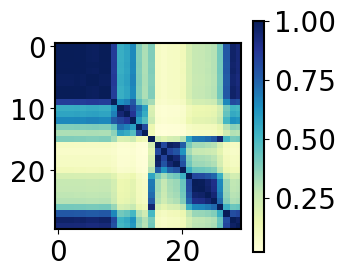

In [68]:
gp_cov = rbf_kernel(y[1], y[1], 1.)
plt.figure(figsize=(3,3))
plt.imshow(gp_cov, cmap='YlGnBu');
plt.colorbar();

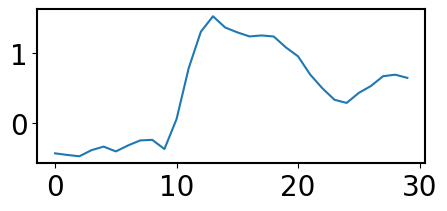

In [65]:
q_y = D.multivariate_normal.MultivariateNormal(
        loc=torch.tensor(data_loader.y_train).mean(0), 
        covariance_matrix=rbf_kernel(torch.linspace(0,29,30), 
                                     torch.linspace(0,29,30),
                                     torch.tensor([.01]))
)
y_sample = q_y.sample((10,))
plt.figure(figsize=(5,2))
plt.plot(y_sample[0]);

In [70]:
class SVI(torch.nn.Module):

    def __init__(self, 
                 Nk, Nt, Nc, Nd, 
                 init_means, init_covs, init_ys,
                 init_bs, init_betas,
                 ks, ts):
        super(SVI, self).__init__()
        self.Nk = Nk
        self.Nt = Nt
        self.Nc = Nc
        self.Nd = Nd
        self.ks = ks
        self.ts = ts
        
        # initialize parameters for variational distribution
        self.means = torch.nn.Parameter(init_means, requires_grad=True)
        self.covs = torch.nn.Parameter(init_covs, requires_grad=True)
        self.bs = torch.nn.Parameter(init_bs, requires_grad=False)
        self.betas = torch.nn.Parameter(init_betas, requires_grad=False)
        
        # initialize parameters for GP
        self.y_support = torch.nn.Parameter(torch.linspace(0,Nt-1,Nt), requires_grad=False)
        # self.gp_mean = torch.nn.Parameter(torch.tensor(init_ys), requires_grad=True)
        # self.gp_sigma = torch.nn.Parameter(torch.tensor([1.]), requires_grad=True)
        self.gp_mean = torch.nn.Parameter(torch.randn((Nk,Nt)), requires_grad=True)
        self.gp_sigma = torch.nn.Parameter(torch.ones((Nk,)), requires_grad=True)
        
        # prior for y
        self.y_prior = D.multivariate_normal.MultivariateNormal(
                            loc=torch.tensor(init_ys), 
                            covariance_matrix=rbf_kernel(
                                self.y_support, self.y_support,
                                torch.tensor([1.])
                            )
            )
        
        
    def forward(self, s, M=1000):
        '''
        M = number of Monte Carlo samples to be drawn.
        '''
        # FIX: ALLOW K GP PRIORS ?
        # specify the variational dist. for y
        # self.y = D.multivariate_normal.MultivariateNormal(
        #                     loc=self.gp_mean, 
        #                     covariance_matrix=rbf_kernel(
        #                         self.y_support, self.y_support,
        #                         1./(torch.square(self.gp_sigma))
        #                     )
        #     )
        self.y = []
        for k in range(Nk):
            self.y.append( D.multivariate_normal.MultivariateNormal(
                                loc=self.gp_mean[k], 
                                covariance_matrix=rbf_kernel(
                                    self.y_support, self.y_support,
                                    1./(torch.square(self.gp_sigma[k]))
                                )
                            )
                         )
        
        # sampling y 
        # FIX: 
        self.q_y = torch.zeros((Nk, Nt))
        for k in range(Nk):
            self.q_y[k] = self.y[k].sample((M,)).mean(0)
        
        
        # compute log-lambdas
        log_lambdas = torch.zeros((self.Nk, self.Nc, self.Nt))
        for k in range(self.Nk):
            for t in range(self.Nt):
                log_lambdas[k,:,t] = self.bs + self.betas[:,t] @ self.q_y[k]
        
        # compute mixing proportions 
        self.log_pis = log_lambdas - torch.logsumexp(log_lambdas, 1)[:,None,:]
        
        
        # specify the variational dist. for z
        z = []
        for k in range(Nk):
            z_k = []
            for t in range(Nt):
                z_k.append(D.categorical.Categorical(probs=torch.exp(self.log_pis)[k,:,t]))
            z.append(z_k)
        
        # Unlike CAVI where we have exact formula for q(z), 
        # we'd have to sample z from q in SVI.
        # sampling z
        # FIX: 
        q_z = []
        for k in range(Nk):
            q_z_k = []
            for t in range(Nt):
                k_t_idx = np.intersect1d(self.ks[k], self.ts[t])
                z_sample = z[k][t].sample((s[k_t_idx].shape[0], M))
                q_z_k_t = torch.zeros((s[k_t_idx].shape[0], Nc))
                for j in range(Nc):
                    q_z_k_t[:,j] = (z_sample == j).sum(1) / M
                q_z_k.append(q_z_k_t)
            q_z.append(q_z_k)
                    
        
        # compute log-likelihood for s as mixture density
        ll = torch.zeros((s.shape[0], self.Nc))
        for j in range(self.Nc):
            ll[:,j] = D.multivariate_normal.MultivariateNormal(
                            loc=self.means[j], 
                            covariance_matrix=self.covs[j]
                        ).log_prob(s)
            
        
        # FIX: WRONG ELBO ! 
        # compute ELBO = E_z,y[logp(s,z,y)] - E_z,y[logq(z,y)]
        # E_z,y[logp(s,z,y)] = E_z,y[logp(s|z) + logp(z|y) + logp(y)]
        
        # E_z[logp(s|z)]
        log_p_s_cond_z = 0
        for k in range(Nk):
            for t in range(Nt):
                k_t_idx = np.intersect1d(self.ks[k], self.ts[t])
                log_p_s_cond_z += (q_z[k][t] * ll[k_t_idx]).sum()
        
        # E_z[logp(z|y)]
        log_p_z_cond_y = 0
        for k in range(Nk):
            for t in range(Nt):
                log_p_z_cond_y += (q_z[k][t] * self.log_pis[k,:,t]).sum()
        
        # E_q(y)[logp(y)] (need differenial entropy?)
        log_p_y = 0
        for k in range(Nk):
            log_p_y += (self.y[k].log_prob(self.q_y[k]).exp() * self.y_prior.log_prob(self.q_y[k])).sum()
        
        # Entropy E_z[logq(z)] 
        entropy_z = 0
        for k in range(Nk):
            for t in range(Nt):
                entropy_z += (q_z[k][t] * safe_log(q_z[k][t])).sum()
        
        # Entropy E_q(y)[logq(y)] (need differenial entropy?)
        entropy_y = 0
        for k in range(Nk):
            entropy_y += (self.y[k].log_prob(self.q_y[k]).exp() * self.y[k].log_prob(self.q_y[k])).sum()
        
        # print(f'E_z[logp(s|z)] = {log_p_s_cond_z}')
        # print(f'E_z[logp(z|y)] = {log_p_z_cond_y}')
        # print(f'E_y[logp(y)] = {log_p_y}')
        # print(f'E_z[logq(z)] = {entropy_z}')
        # print(f'E_y[logq(y)] = {entropy_y}')
        
        return log_p_s_cond_z + log_p_z_cond_y + log_p_y - entropy_z - entropy_y

In [71]:
enc = np.load(save_path + f'cont_y_enc_res_c{Nc}.npy', allow_pickle=True).item()

In [72]:
svi = SVI(Nk, Nt, Nc, Nd, 
          enc['means'].requires_grad_(False), 
          enc['covs'].requires_grad_(False), 
          data_loader.y_train.mean(0),
          enc['bs'].requires_grad_(False),
          enc['betas'].requires_grad_(False),
          test_k_ids, test_t_ids)
optim = torch.optim.Adam(svi.parameters(), lr=1e-1)

In [73]:
%%time
max_iter = 100
elbos = []
for i in range(max_iter):
    elbo = svi(s, M=1000)
    loss = - elbo 
    print(f'iter: {i+1} elbo: {elbo:.2f}')
    elbos.append(elbo)
    optim.zero_grad()
    loss.backward()
    optim.step()

iter: 1 elbo: -44994016.37
iter: 2 elbo: -44348860.90
iter: 3 elbo: -44105340.30
iter: 4 elbo: -43216361.21
iter: 5 elbo: -43679984.84
iter: 6 elbo: -42631767.95
iter: 7 elbo: -42847866.36
iter: 8 elbo: -42050321.28
iter: 9 elbo: -42269898.13
iter: 10 elbo: -41894038.03
iter: 11 elbo: -41393719.34
iter: 12 elbo: -41239204.53
iter: 13 elbo: -40737084.89
iter: 14 elbo: -40457980.41
iter: 15 elbo: -40289156.12
iter: 16 elbo: -39674515.37
iter: 17 elbo: -39934836.19
iter: 18 elbo: -39088262.45
iter: 19 elbo: -39401976.88
iter: 20 elbo: -38828960.14
iter: 21 elbo: -38962006.20
iter: 22 elbo: -39137813.90
iter: 23 elbo: -38266998.82
iter: 24 elbo: -38076227.74
iter: 25 elbo: -38323046.32
iter: 26 elbo: -38045941.19
iter: 27 elbo: -37613661.90
iter: 28 elbo: -37087611.24
iter: 29 elbo: -37534178.60
iter: 30 elbo: -37213699.79
iter: 31 elbo: -36614097.85
iter: 32 elbo: -36755346.75
iter: 33 elbo: -36599872.65
iter: 34 elbo: -36614170.79
iter: 35 elbo: -36253233.47
iter: 36 elbo: -36230436.72
i

In [74]:
elbos = [elbo.detach().numpy() for elbo in elbos]

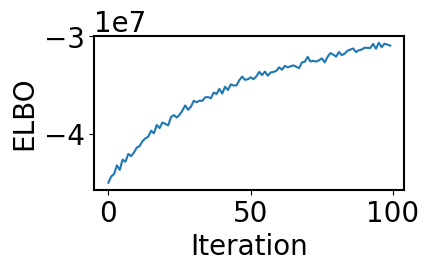

In [75]:
plt.figure(figsize=(4,2))
plt.plot(elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO");

In [76]:
svi.gp_sigma

Parameter containing:
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
       requires_grad=True)

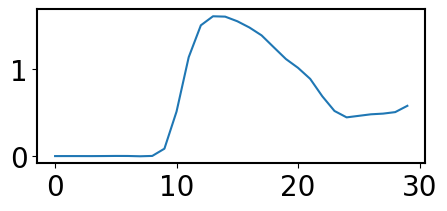

In [77]:
plt.figure(figsize=(5,2))
plt.plot(svi.y_prior.loc.detach().numpy());

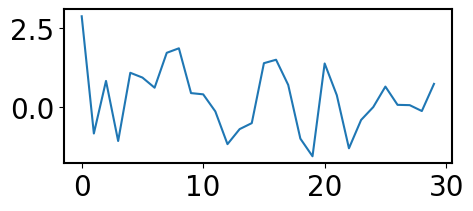

In [83]:
plt.figure(figsize=(5,2))
plt.plot(svi.q_y[5].detach().numpy());

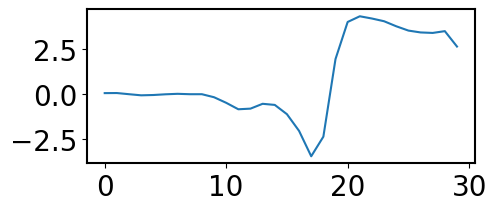

In [79]:
plt.figure(figsize=(5,2))
plt.plot(y[2]);

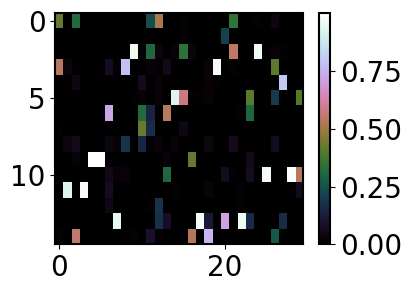

In [80]:
plt.figure(figsize=(4,3))
plt.imshow(torch.exp(svi.log_pis[0]).detach().numpy(), 
           aspect='auto', cmap='cubehelix')
plt.colorbar();